# What are the top 10 growing suburbs in Victoria?

The regression notebook aims to find the most important features in predicting rental prices through the use of regression models and growth rates calculated through time series on the `Quarterly_rent_analysis.ipynb` notebook

This notebook will go through EDA, regression models, hyperparameter tuning, performance evaluation and graphing

The results of this notebook will be particularly relevant to potential property investors and developers, looking to gain optimal return on their investments

Setting up notebook

In [205]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.sql.types import *
from pyspark.sql import SparkSession, functions as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from sklearn.datasets import make_regression
from xgboost import XGBRegressor
from matplotlib import pyplot

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

import warnings
warnings.filterwarnings("ignore") # suppress warnings

In [206]:
# Load in Dataframes
sdf = spark.read.parquet('../data/curated/properties_population.parquet')
growth = spark.read.parquet('../data/curated/growth_rate_20years.parquet')
distances = spark.read.parquet('../data/curated/distances.parquet')
distances = distances.toPandas()

In [207]:
distances

,name,postcode,latitude,longitude,distance_to_closest_school_km,distance_to_cbd
0,"(Leased) 3 Yarra Street, South Yarra VIC 3141",3141,-37.838131,144.992734,1.540,5.569
1,"0 Cnr Watson Rd & McPherson Rd, Leongatha VIC ...",3953,-38.468905,145.956614,0.413,136.184
2,"004B/12 Albert Street, Hawthorn East VIC 3123",3123,-37.823602,145.048067,1.237,9.083
3,"04/390 Burwood Highway, Burwood VIC 3125",3125,-37.852123,145.130944,1.409,17.834
4,"04/949 Dandenong Road, Malvern East VIC 3145",3145,-37.878580,145.048328,2.226,14.936
...,...,...,...,...,...,...
12240,"carpark135 Abekcett Street, Melbourne VIC 3000",3000,-37.809788,144.959647,0.659,0.596
12241,"d406/1 Village Mews, Caulfield North VIC 3161",3161,-37.875918,145.037362,2.260,12.272
12242,"rooms 1-7/4 Lanark Court, Wodonga VIC 3690",3690,-36.117231,146.865715,1.518,317.718
12243,"unit 2/530 Whitehorse road, Surrey Hills VIC 3127",3127,-37.815075,145.098750,0.328,18.818


Creating columns to record the type of propety i.e. house, flat, apartment which is extracted from the property_type column

In [208]:
sdf = sdf.withColumn(
    # Properties priced per week
    'House',
    F.when(F.lower(F.col('property_type')).contains('house'), True).otherwise(False)
).withColumn(
    # see if property is priced per annum
    'flat',
    F.when(F.lower(F.col('property_type')).contains('flat') \
        | F.lower(F.col('property_type')).contains('apartment'), True ).otherwise(False)
)

Removing invalid entries

In [209]:
# Dropping all duplicate rows
sdf1 = sdf.dropDuplicates()
sdf1 = sdf1[sdf1['property_type'] != 'Carspace']

growth = growth.filter((F.col('postcode')>0))

# Removing NULL values and getting data from 'All Properties'
columns_to_fill = ['1 bed flats', '2 bed flats', '3 bed flats', '2 bed houses', '3 bed houses', '4 bed houses']

# Setting the growth value of the 'All Properties' column as the default for missing values
for col in columns_to_fill:
    growth = growth.withColumn(col, F.coalesce(growth[col], growth['All Properties']))

The following code sorts the data frame and removes unwanted features

In [210]:
suburbs = growth.dropna()
suburbs_pdf = suburbs.toPandas()

# Sorting by column 'All Properties'
suburbs_pdf = suburbs_pdf.sort_values(by=['All Properties'], ascending = False)
suburbs_pdf = suburbs_pdf[0:10]

# Remove unwanted features
top_10 = suburbs_pdf.drop(['postcode', '1 bed flats', '2 bed flats', '3 bed flats', '2 bed houses', '3 bed houses', '4 bed houses'], axis=1)


Create bar chart showing the top 10 growing suburbs sorted by growth rate (Highest - Lowest)

Map saved as PNG: ../plots/Top10_growing_suburbs.png


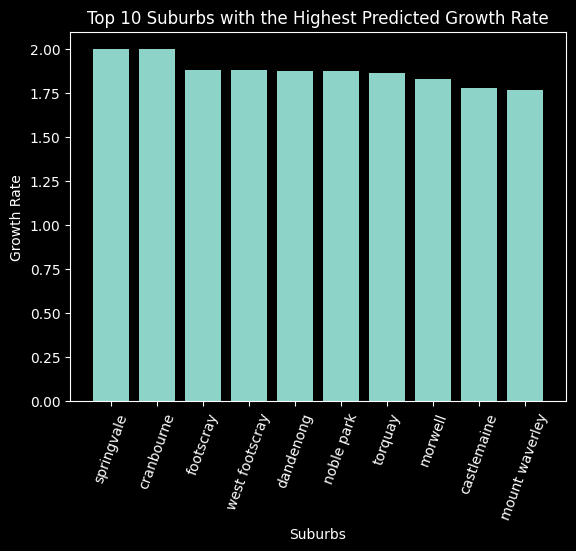

In [211]:
median_pdf = pd.DataFrame(top_10)

# Setting colour preferences
plt.style.use('dark_background')
plt.figure(facecolor='Black')

# creating the bar plot
plt.bar(list(median_pdf['locality']), median_pdf['All Properties'])

# Rotating X-axis labels
plt.xticks(rotation = 70)

# Labelling Graph
plt.xlabel("Suburbs")
plt.ylabel("Growth Rate")
plt.title("Top 10 Suburbs with the Highest Predicted Growth Rate")

# Save the plot to a PNG file (optional)
output_image_path = "../plots/Top10_growing_suburbs.png"
plt.savefig(output_image_path, bbox_inches='tight')

print(f"Map saved as PNG: {output_image_path}")

plt.show()

Based on this graph, we recommend the suburbs shown above as ideal locations for investment opportunities, since the value of properties in these areas is likely to increase in the near future. Springvale is most highly recommended since it is within an hour from the CBD and is less developed than inner city suburbs, so thereby has more potential for growth and financial gain.

Appending growth value to dataframe:

In [212]:
# Change from columns to merge 
growth_unpivoted = growth.select(
    "postcode",
    F.expr("stack(6, '1 bed flats', `1 bed flats`, '2 bed flats', `2 bed flats`, '3 bed flats', \
           `3 bed flats`, '2 bed houses', `2 bed houses`, '3 bed houses', `3 bed houses`, '4 bed houses', \
           `4 bed houses`) as (bed_column, growth_value)")
)

# Create the bed_column in sdf1
sdf1 = sdf1.withColumn(
    "bed_column",
    F.when((F.col("property_type").contains("flat")) & (F.col("beds") == 1), "1 bed flats")
    .when((F.col("property_type").contains("flat")) & (F.col("beds") == 2), "2 bed flats")
    .when((F.col("property_type").contains("flat")) & (F.col("beds") == 3), "3 bed flats")
    .when((F.col("property_type").contains("house")) & (F.col("beds") == 2), "2 bed houses")
    .when((F.col("property_type").contains("house")) & (F.col("beds") == 3), "3 bed houses")
    .when((F.col("property_type").contains("house")) & (F.col("beds") == 4), "4 bed houses")
)

# Perform the join after ensuring both DataFrames have 'postcode' and 'bed_column'
sdf_growth = sdf1.join(growth_unpivoted, on=['postcode', 'bed_column'], how='inner')

# Show the result
sdf_growth = sdf_growth.drop('flat')
sdf_growth = sdf_growth.drop('House')

sdf_growth.show()

+--------+------------+------+--------------+---------+-------------+----+-----+-------+--------------------+--------------------+----------------------------+------------------------------+-----------------------+-------------------+-----------+---------------------------+----------+-----------------------------------+-------------------------------------+------------------+
|postcode|  bed_column|  cost|        suburb|furnished|property_type|beds|baths|parking|              region|           lgaregion|total male population - 2021|total female population - 2021|total population - 2021|australian citizens|median rent|median family weekly income|median age|total region male population - 2022|total region female population - 2022|      growth_value|
+--------+------------+------+--------------+---------+-------------+----+-----+-------+--------------------+--------------------+----------------------------+------------------------------+-----------------------+-------------------+--------

Merging with quarterly rent analysis


In [213]:
# Removing categorical and unnecessary features
pdf_reg = sdf_growth.toPandas()
pdf_reg['postcode'] = pdf_reg['postcode'].astype(str)
pdf_reg = pdf_reg.drop(['region', 'lgaregion', 'suburb', 'bed_column', 'total region female population - 2022', \
                        'property_type', 'total region male population - 2022'], axis = 1)
distances = distances.drop(['name', 'latitude', 'longitude'], axis = 1)

distances = distances.groupby('postcode').mean()
distances = distances.dropna()

In [214]:
growth_pdf = growth.toPandas()
df_merged = pd.merge(pdf_reg, distances, on='postcode', how='inner')
df_merged = df_merged.drop_duplicates()
df_merged.to_parquet('../data/curated/regression_data.parquet', engine='pyarrow', index=False)
df_merged = df_merged.dropna()
df_merged

,postcode,cost,furnished,beds,baths,parking,total male population - 2021,total female population - 2021,total population - 2021,australian citizens,median rent,median family weekly income,median age,growth_value,distance_to_closest_school_km,distance_to_cbd
0,3187,1300.0,0,4.0,3.0,3,8014,8744,16757,14596,600,3400,45,1.307692,0.667444,14.428361
1,3207,1600.0,0,3.0,2.0,1,8439,9196,17633,14528,540,3264,42,1.209302,1.544370,5.327425
2,3204,1090.0,0,4.0,3.0,2,16140,16991,33130,27132,461,2860,39,2.030303,0.815452,16.923560
3,3044,450.0,0,2.0,1.0,1,13847,14847,28701,24665,401,2568,37,1.619048,0.775736,11.312321
4,3040,600.0,0,2.0,2.0,1,12997,13727,26722,23487,385,2974,39,1.227273,1.096919,11.138174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,3040,670.0,0,3.0,3.0,2,12997,13727,26722,23487,385,2974,39,1.521739,1.096919,11.138174
717,3046,525.0,0,2.0,2.0,1,18287,18483,36772,27661,371,2053,35,1.500000,0.723039,13.928184
718,3204,620.0,0,2.0,1.0,1,16140,16991,33130,27132,461,2860,39,1.375000,0.815452,16.923560
719,3043,650.0,0,3.0,2.0,2,8872,9047,17912,15436,375,1881,41,1.400000,1.512000,18.030444


Barchart of the Lowest Median Rent by Suburb

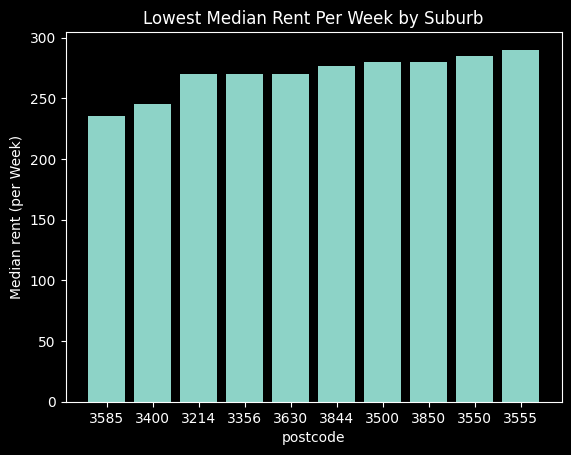

In [215]:
medians = df_merged.groupby(["postcode"])["median rent"].median() 
median_pdf = pd.DataFrame(medians)
median_pdf = median_pdf.sort_values(by=['median rent'])

# creating the bar plot
plt.bar(list(median_pdf[0:10].index), median_pdf['median rent'][0:10]) # fix x label, fix outliers, data check

plt.xlabel("postcode")
plt.ylabel("Median rent (per Week)")
plt.title("Lowest Median Rent Per Week by Suburb")
plt.show()

Barchart of the Highest Median Rent by Postcode

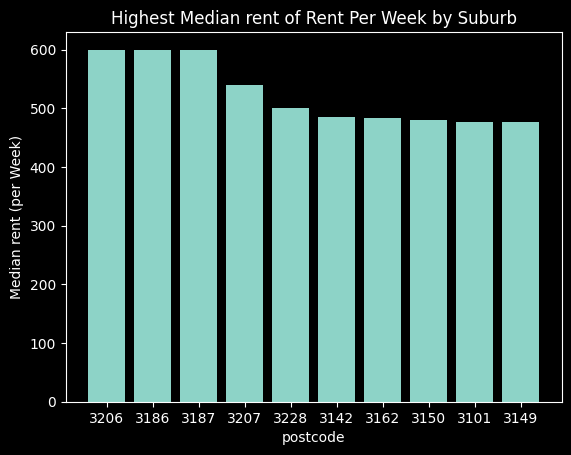

In [216]:
medians = df_merged.groupby(["postcode"])["median rent"].median() 
median_pdf = pd.DataFrame(medians)
median_pdf = median_pdf.sort_values(by=['median rent'], ascending = False)

# creating the bar plot
plt.bar(list(median_pdf[0:10].index), median_pdf['median rent'][0:10]) # fix x label

plt.xlabel("postcode")
plt.ylabel("Median rent (per Week)")
plt.title("Highest Median rent of Rent Per Week by Suburb")
plt.show()

Distribution of Median Rent by Suburb

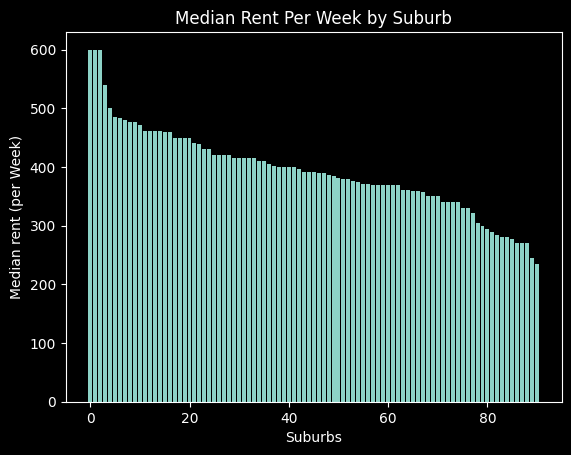

In [217]:
means = df_merged.groupby(["postcode"])["median rent"].mean() 
means_pdf = pd.DataFrame(means)
means_pdf = means_pdf.sort_values(by=['median rent'], ascending = False)

# creating the bar plot
plt.bar([x for x in range(len(list(means_pdf.index)))], means_pdf['median rent']) # can input top 10 indices

plt.xlabel("Suburbs")
plt.ylabel("Median rent (per Week)")
plt.title("Median Rent Per Week by Suburb")
plt.show()

Scatterplot exploring correlation between 'median rent' and 'median family weekly income'

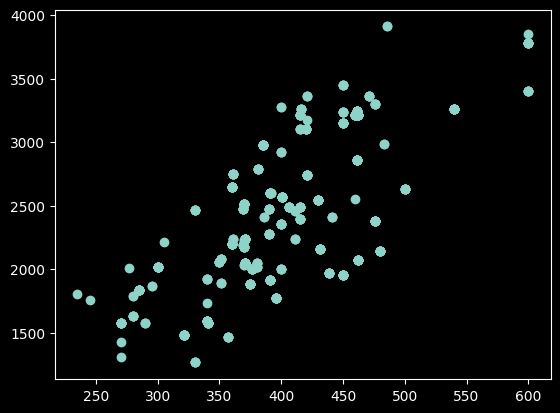

In [218]:
plt.scatter(df_merged['median rent'], df_merged['median family weekly income'])
plt.show()

Merging dataframes by Postcode:

In [219]:
df_merged = df_merged.round()
df_merged = df_merged.dropna()
df_merged = df_merged.drop_duplicates()
suburbs = df_merged.groupby(['postcode']).median()
suburbs = suburbs.astype(int)
suburbs

,cost,furnished,beds,baths,parking,total male population - 2021,total female population - 2021,total population - 2021,australian citizens,median rent,median family weekly income,median age,growth_value,distance_to_closest_school_km,distance_to_cbd
postcode,,,,,,,,,,,,,,,
3008,1025,0,3,2,2,8037,7458,15495,6983,411,2461,32,1,1,3
3011,700,0,3,2,1,11361,10913,22278,16807,369,2474,34,2,1,7
3012,635,0,3,2,1,13593,13423,27023,21594,370,2513,35,2,1,10
3013,695,0,3,2,1,7603,8038,15636,13764,462,3216,37,2,1,9
3015,650,0,3,2,2,9144,9492,18634,16402,460,3214,38,2,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3810,575,0,3,2,2,27135,28453,55588,46026,351,1894,33,2,1,61
3844,430,0,2,1,1,15074,16106,31179,27704,277,2007,40,1,1,165
3850,390,0,2,1,1,7408,8063,15472,13824,280,1787,42,2,1,216


Needed to create a rounded version of the median rent for graphical purposes - essentially binning the prices so similar prices are grouped together

In [220]:
# Round up to the nearest 10
rounded_median_rent= [(np.ceil(x/10) * 10) for x in list(df_merged['median rent'].values)]
rounded_median_rent = [int(x) for x in rounded_median_rent]
df_merged['rounded_median_rent'] = rounded_median_rent

Resolving feature redundancies - don't need male, female and total population.


In [221]:
df_merged['total_pop_2021'] = df_merged['total male population - 2021']+df_merged['total female population - 2021']
df_merged = df_merged.drop('total male population - 2021', axis = 1)
df_merged = df_merged.drop('total female population - 2021', axis=1)
df_merged = df_merged.drop('total population - 2021', axis=1)
df_merged = df_merged.drop('postcode', axis=1)
df_merged.rename(columns={'median family weekly income': 'household_weekly_income'}, inplace=True)
df_merged

,cost,furnished,beds,baths,parking,australian citizens,median rent,household_weekly_income,median age,growth_value,distance_to_closest_school_km,distance_to_cbd,rounded_median_rent,total_pop_2021
0,1300.0,0,4.0,3.0,3,14596,600,3400,45,1.0,1.0,14.0,600,16758
1,1600.0,0,3.0,2.0,1,14528,540,3264,42,1.0,2.0,5.0,540,17635
2,1090.0,0,4.0,3.0,2,27132,461,2860,39,2.0,1.0,17.0,470,33131
3,450.0,0,2.0,1.0,1,24665,401,2568,37,2.0,1.0,11.0,410,28694
4,600.0,0,2.0,2.0,1,23487,385,2974,39,1.0,1.0,11.0,390,26724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,670.0,0,3.0,3.0,2,23487,385,2974,39,2.0,1.0,11.0,390,26724
717,525.0,0,2.0,2.0,1,27661,371,2053,35,2.0,1.0,14.0,380,36770
718,620.0,0,2.0,1.0,1,27132,461,2860,39,1.0,1.0,17.0,470,33131
719,650.0,0,3.0,2.0,2,15436,375,1881,41,1.0,2.0,18.0,380,17919


Correlation map

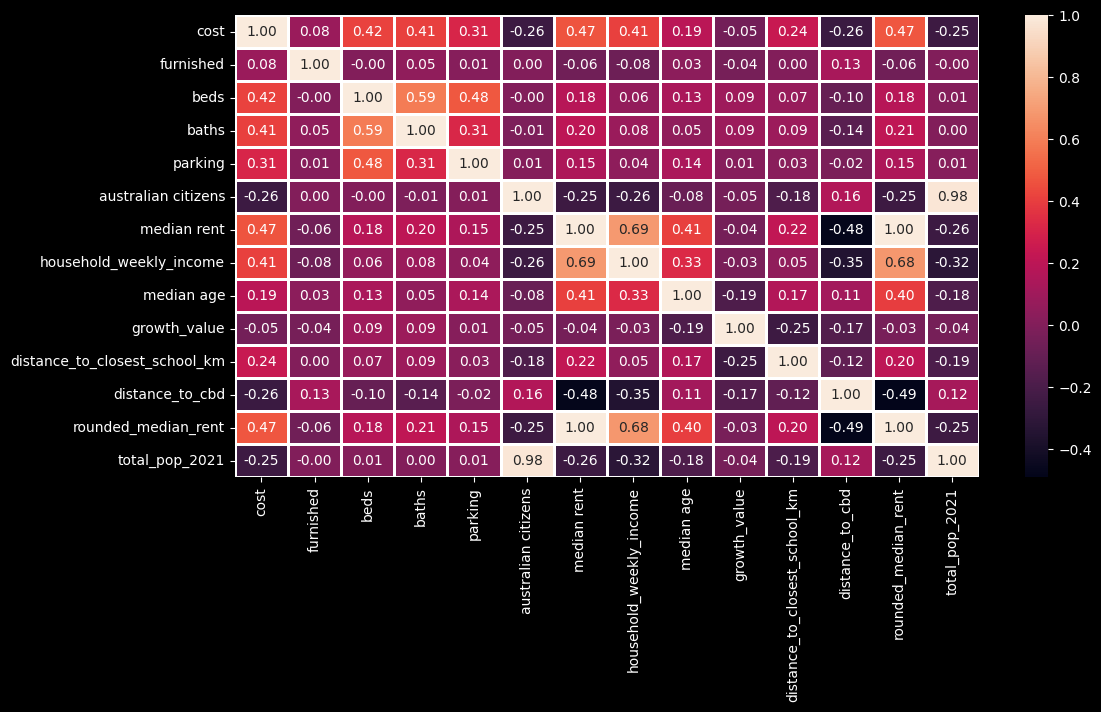

In [222]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_merged.corr(), fmt = '.2f',
            linewidths = 2, annot = True)

# Save the plot to a PNG file (optional)
output_image_path = "../plots/Heatmap.png"
plt.savefig(output_image_path, bbox_inches='tight')

Applying log transforms to features containing excessively large numeric values

In [223]:
from math import log

# Calculating logarithmic values for the specified column
df_merged['rounded_median_rent'] = df_merged['rounded_median_rent'].apply(lambda x: log(x))
df_merged['total_pop_2021'] = df_merged['total_pop_2021'].apply(lambda x: log(x))
df_merged['household_weekly_income'] = df_merged['household_weekly_income'].apply(lambda x: log(x))
df_merged['australian citizens'] = df_merged['australian citizens'].apply(lambda x: log(x))
df_merged['median rent'] = df_merged['median rent'].apply(lambda x: log(x))
target = df_merged['cost'] # don't want cost scaled
df_merged = df_merged.dropna()
df_merged

,cost,furnished,beds,baths,parking,australian citizens,median rent,household_weekly_income,median age,growth_value,distance_to_closest_school_km,distance_to_cbd,rounded_median_rent,total_pop_2021
0,1300.0,0,4.0,3.0,3,9.588503,6.396930,8.131531,45,1.0,1.0,14.0,6.396930,9.726631
1,1600.0,0,3.0,2.0,1,9.583833,6.291569,8.090709,42,1.0,2.0,5.0,6.291569,9.777641
2,1090.0,0,4.0,3.0,2,10.208469,6.133398,7.958577,39,2.0,1.0,17.0,6.152733,10.408225
3,450.0,0,2.0,1.0,1,10.113141,5.993961,7.850883,37,2.0,1.0,11.0,6.016157,10.264443
4,600.0,0,2.0,2.0,1,10.064202,5.953243,7.997663,39,1.0,1.0,11.0,5.966147,10.193317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,670.0,0,3.0,3.0,2,10.064202,5.953243,7.997663,39,2.0,1.0,11.0,5.966147,10.193317
717,525.0,0,2.0,2.0,1,10.227779,5.916202,7.627057,35,2.0,1.0,14.0,5.940171,10.512438
718,620.0,0,2.0,1.0,1,10.208469,6.133398,7.958577,39,1.0,1.0,17.0,6.152733,10.408225
719,650.0,0,3.0,2.0,2,9.644458,5.926926,7.539559,41,1.0,2.0,18.0,5.940171,9.793617


*Creating a train-test split in the data so we can train our regression models and test their performance*

In [224]:
# Label
y = target

# Predictors
x = df_merged.drop(['cost'], axis=1)

# Create train, test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=10)

In [225]:
attr = df_merged.columns
attr

Index(['cost', 'furnished', 'beds', 'baths', 'parking', 'australian citizens',
       'median rent', 'household_weekly_income', 'median age', 'growth_value',
       'distance_to_closest_school_km', 'distance_to_cbd',
       'rounded_median_rent', 'total_pop_2021'],
      dtype='object')

In [226]:
df_merged

,cost,furnished,beds,baths,parking,australian citizens,median rent,household_weekly_income,median age,growth_value,distance_to_closest_school_km,distance_to_cbd,rounded_median_rent,total_pop_2021
0,1300.0,0,4.0,3.0,3,9.588503,6.396930,8.131531,45,1.0,1.0,14.0,6.396930,9.726631
1,1600.0,0,3.0,2.0,1,9.583833,6.291569,8.090709,42,1.0,2.0,5.0,6.291569,9.777641
2,1090.0,0,4.0,3.0,2,10.208469,6.133398,7.958577,39,2.0,1.0,17.0,6.152733,10.408225
3,450.0,0,2.0,1.0,1,10.113141,5.993961,7.850883,37,2.0,1.0,11.0,6.016157,10.264443
4,600.0,0,2.0,2.0,1,10.064202,5.953243,7.997663,39,1.0,1.0,11.0,5.966147,10.193317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,670.0,0,3.0,3.0,2,10.064202,5.953243,7.997663,39,2.0,1.0,11.0,5.966147,10.193317
717,525.0,0,2.0,2.0,1,10.227779,5.916202,7.627057,35,2.0,1.0,14.0,5.940171,10.512438
718,620.0,0,2.0,1.0,1,10.208469,6.133398,7.958577,39,1.0,1.0,17.0,6.152733,10.408225
719,650.0,0,3.0,2.0,2,9.644458,5.926926,7.539559,41,1.0,2.0,18.0,5.940171,9.793617


In [227]:
df_merged.rename(columns={'australian citizens': 'aus_citizens'}, inplace=True)
df_merged.rename(columns={'median rent': 'median_rent', 'median age': 'median_age', \
                          'median family weekly income': 'household_weekly_income'}, inplace=True)
df_merged

,cost,furnished,beds,baths,parking,aus_citizens,median_rent,household_weekly_income,median_age,growth_value,distance_to_closest_school_km,distance_to_cbd,rounded_median_rent,total_pop_2021
0,1300.0,0,4.0,3.0,3,9.588503,6.396930,8.131531,45,1.0,1.0,14.0,6.396930,9.726631
1,1600.0,0,3.0,2.0,1,9.583833,6.291569,8.090709,42,1.0,2.0,5.0,6.291569,9.777641
2,1090.0,0,4.0,3.0,2,10.208469,6.133398,7.958577,39,2.0,1.0,17.0,6.152733,10.408225
3,450.0,0,2.0,1.0,1,10.113141,5.993961,7.850883,37,2.0,1.0,11.0,6.016157,10.264443
4,600.0,0,2.0,2.0,1,10.064202,5.953243,7.997663,39,1.0,1.0,11.0,5.966147,10.193317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,670.0,0,3.0,3.0,2,10.064202,5.953243,7.997663,39,2.0,1.0,11.0,5.966147,10.193317
717,525.0,0,2.0,2.0,1,10.227779,5.916202,7.627057,35,2.0,1.0,14.0,5.940171,10.512438
718,620.0,0,2.0,1.0,1,10.208469,6.133398,7.958577,39,1.0,1.0,17.0,6.152733,10.408225
719,650.0,0,3.0,2.0,2,9.644458,5.926926,7.539559,41,1.0,2.0,18.0,5.940171,9.793617


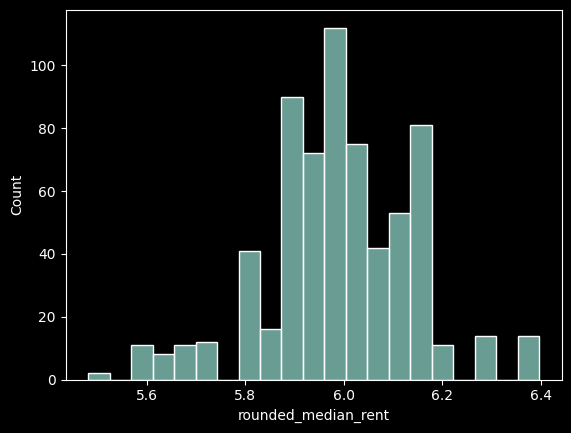

In [228]:
# Visualizing the distribution of rounded median rent
sns.histplot(df_merged['rounded_median_rent'])
plt.show()

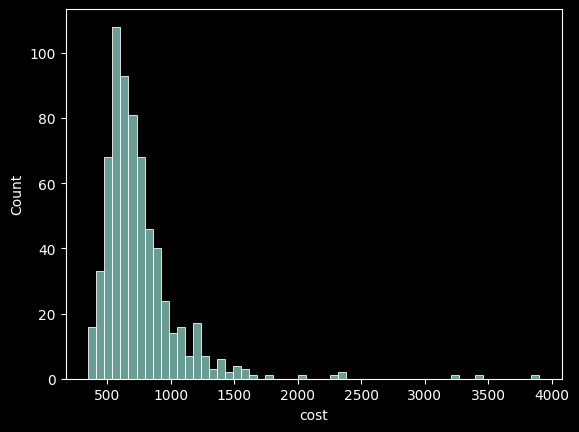

In [229]:
# Visualizing the distribution of rental cost
sns.histplot(df_merged['cost'])
plt.show()

In [230]:
df_merged.describe()

,cost,furnished,beds,baths,parking,aus_citizens,median_rent,household_weekly_income,median_age,growth_value,distance_to_closest_school_km,distance_to_cbd,rounded_median_rent,total_pop_2021
count,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000
mean,751.254135,0.024060,2.941353,1.983459,1.568421,10.005552,5.983301,7.763964,38.139850,1.509774,1.120301,36.962406,5.993774,10.232320
std,321.578866,0.153351,0.670722,0.648002,0.610077,0.497526,0.154002,0.237468,3.638812,0.500281,0.325558,59.964147,0.153115,0.484610
min,350.000000,0.000000,2.000000,1.000000,0.000000,7.744137,5.459586,7.145196,28.000000,1.000000,1.000000,3.000000,5.480639,8.060540
25%,570.000000,0.000000,2.000000,2.000000,1.000000,9.640693,5.913503,7.601402,36.000000,1.000000,1.000000,12.000000,5.913503,9.832850
50%,680.000000,0.000000,3.000000,2.000000,2.000000,9.998661,5.968708,7.776115,38.000000,2.000000,1.000000,20.000000,5.991465,10.193317
75%,850.000000,0.000000,3.000000,2.000000,2.000000,10.227779,6.109248,7.958577,41.000000,2.000000,1.000000,34.000000,6.109248,10.512438
max,3900.000000,1.000000,4.000000,4.000000,4.000000,11.459788,6.396930,8.271037,50.000000,2.000000,2.000000,543.000000,6.396930,11.688583


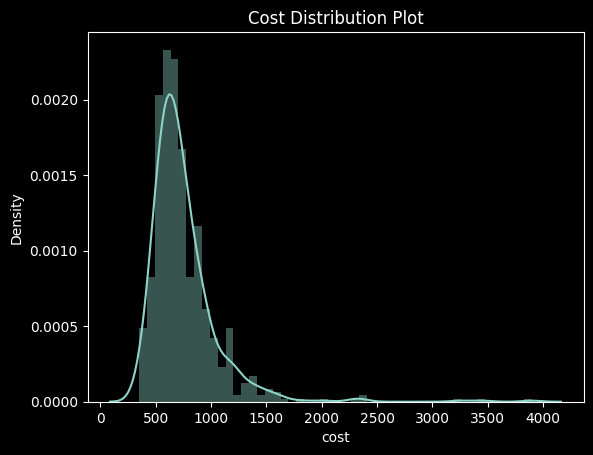

In [231]:
# Data distribution
plt.title('Cost Distribution Plot')
sns.distplot(target)
plt.show()

The aim of the regression is to find a model that is well able to capture the relationships within the data. We want the model to perform well on both training and testing data and use this model to rank the most important features

Defining Variables for Regression

In [232]:
# Splitting variables
X = df_merged.iloc[:, 1:].values  # independent
y = df_merged.iloc[:,0].values  # dependent

Fitting and Evaluating Gradient Boosting Regressor model:

In [233]:
# Boosting
model = GradientBoostingRegressor(random_state=0).fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.7899306420082561
0.4504516619333353


Visualising Gradient Boosting Regressor model performance

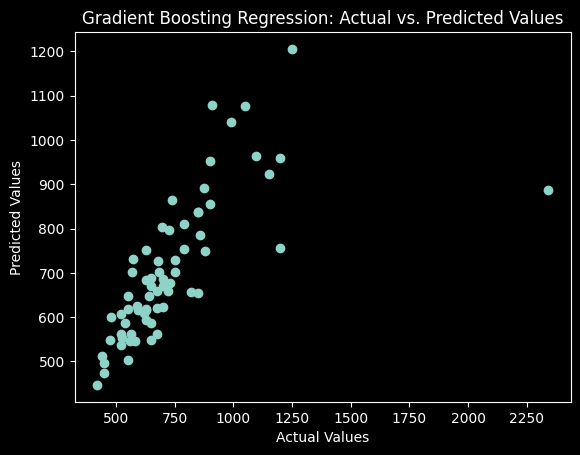

In [234]:
plt.scatter(y_test, model.predict(X_test)) # Add y=x
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Gradient Boosting Regression: Actual vs. Predicted Values")
plt.show()

In [235]:
features = df_merged.drop('cost', axis = 1).columns
df = pd.DataFrame(list(features), columns = ['Features'])

Fitting and Evaluating XGB Regressor model:

Feature: 0, Score: 0.02814
Feature: 1, Score: 0.13073
Feature: 2, Score: 0.03735
Feature: 3, Score: 0.05407
Feature: 4, Score: 0.02098
Feature: 5, Score: 0.15689
Feature: 6, Score: 0.32046
Feature: 7, Score: 0.04214
Feature: 8, Score: 0.03472
Feature: 9, Score: 0.05946
Feature: 10, Score: 0.10561
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00945


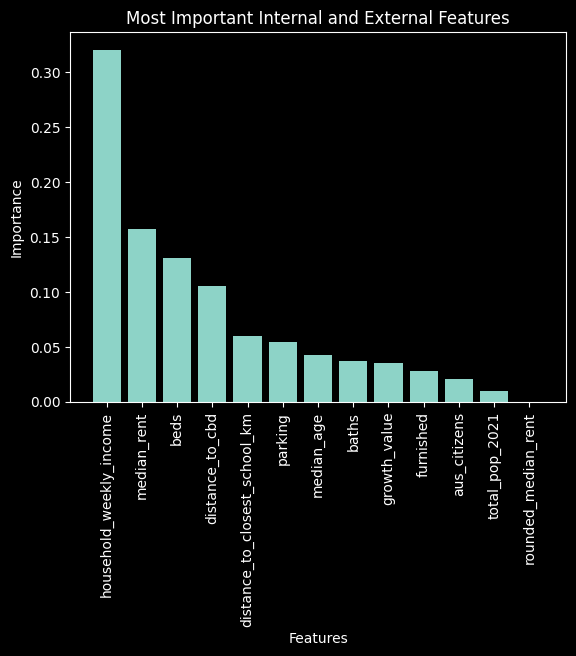

In [236]:
# xgboost for feature importance on a regression problem
model = XGBRegressor()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_

features_lst = []
importances = []
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
 importances.append(abs(v))
 features_lst.append(df_merged.columns[i])
# plot feature importance

df['Importance'] = (importances)
df = df.sort_values('Importance', ascending=False)

features = df_merged.drop('cost', axis = 1).columns
df = pd.DataFrame(list(features), columns = ['Features'])
df['Importance'] = (importances)
df = df.sort_values('Importance', ascending=False)

plt.xticks(rotation = 90)
pyplot.bar(df['Features'], df['Importance'])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Most Important Internal and External Features")

# Save the plot to a PNG file (optional)
output_image_path = "../plots/Feature_Importances.png"
plt.savefig(output_image_path, bbox_inches='tight')

plt.show()


Evaluating XGB model performance:

In [237]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.8531679628303895
0.6781350329836393


Exploring General Linear Model. Various models were tried and the Poisson family produced the highest relative pseudo-R-Squared score so the results of the Poisson Family Model are shown below:

In [242]:
# Adding a constant to the predictor variable set
X = sm.add_constant(X_train)
X = np.array(X, dtype = int)
y = np.array(y_train, dtype = int)

# Logistic Regression model
model = sm.GLM(y, X, family=sm.families.Poisson()).fit() # highest relative pseudo-R-squared score compared to other models

# Model summary
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  598
Model:                            GLM   Df Residuals:                      584
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15930.
Date:                Fri, 18 Oct 2024   Deviance:                       26837.
Time:                        23:12:25   Pearson chi2:                 3.35e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8686      0.051     76.557      0.0

Visualising performance of GLM with Poisson family model:

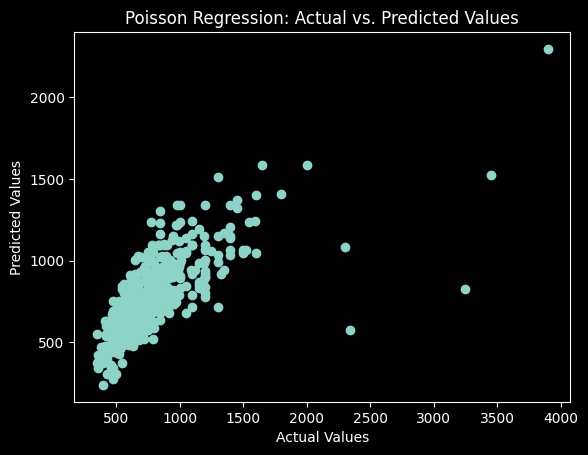

In [239]:
plt.scatter(y, model.predict(X))
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Poisson Regression: Actual vs. Predicted Values")
plt.show()

The Gamma family model also achieved a relatively high pseudo-R-square score. The results are shown below:

In [240]:
# Adding a constant to the predictor variable set
X = sm.add_constant(X_train)
X = np.array(X, dtype = int)
y = np.array(y_train, dtype = int)

# Logistic Regression model
model = sm.GLM((y), (X), family=sm.families.Gamma()).fit() # high relative pseudo-R-squared score compared to other models

# Model summary
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  598
Model:                            GLM   Df Residuals:                      584
Model Family:                   Gamma   Df Model:                           13
Link Function:           InversePower   Scale:                        0.068677
Method:                          IRLS   Log-Likelihood:                -3868.2
Date:                Fri, 18 Oct 2024   Deviance:                       26.277
Time:                        22:27:56   Pearson chi2:                     40.1
No. Iterations:                     8   Pseudo R-squ. (CS):             0.6808
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.000      9.075      0.0

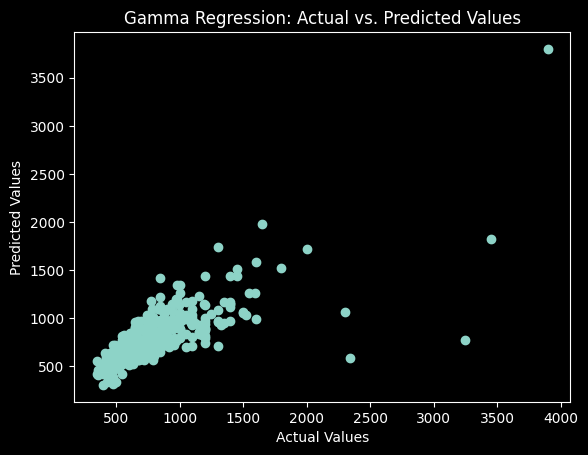

In [241]:
plt.scatter(y, model.predict(X))
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Gamma Regression: Actual vs. Predicted Values")
plt.show() # Better performance is outliers are excluded